# Exercises - Forward Rates

#### Notation Commands

$$\newcommand{\Black}{\mathcal{B}}
\newcommand{\Blackcall}{\Black_{\mathrm{call}}}
\newcommand{\Blackput}{\Black_{\mathrm{put}}}
\newcommand{\EcondS}{\hat{S}_{\mathrm{conditional}}}
\newcommand{\Efwd}{\mathbb{E}^{T}}
\newcommand{\Ern}{\mathbb{E}^{\mathbb{Q}}}
\newcommand{\Tfwd}{T_{\mathrm{fwd}}}
\newcommand{\Tunder}{T_{\mathrm{bond}}}
\newcommand{\accint}{A}
\newcommand{\carry}{\widetilde{\cpn}}
\newcommand{\cashflow}{C}
\newcommand{\convert}{\phi}
\newcommand{\cpn}{c}
\newcommand{\ctd}{\mathrm{CTD}}
\newcommand{\disc}{Z}
\newcommand{\done}{d_{1}}
\newcommand{\dt}{\Delta t}
\newcommand{\dtwo}{d_{2}}
\newcommand{\flatvol}{\sigma_{\mathrm{flat}}}
\newcommand{\flatvolT}{\sigma_{\mathrm{flat},T}}
\newcommand{\float}{\mathrm{flt}}
\newcommand{\freq}{m}
\newcommand{\futprice}{\mathcal{F}(t,T)}
\newcommand{\futpriceDT}{\mathcal{F}(t+h,T)}
\newcommand{\futpriceT}{\mathcal{F}(T,T)}
\newcommand{\futrate}{\mathscr{f}}
\newcommand{\fwdprice}{F(t,T)}
\newcommand{\fwdpriceDT}{F(t+h,T)}
\newcommand{\fwdpriceT}{F(T,T)}
\newcommand{\fwdrate}{f}
\newcommand{\fwdvol}{\sigma_{\mathrm{fwd}}}
\newcommand{\fwdvolTi}{\sigma_{\mathrm{fwd},T_i}}
\newcommand{\grossbasis}{B}
\newcommand{\hedge}{\Delta}
\newcommand{\ivol}{\sigma_{\mathrm{imp}}}
\newcommand{\logprice}{p}
\newcommand{\logyield}{y}
\newcommand{\mat}{(n)}
\newcommand{\nargcond}{d_{1}}
\newcommand{\nargexer}{d_{2}}
\newcommand{\netbasis}{\tilde{\grossbasis}}
\newcommand{\normcdf}{\mathcal{N}}
\newcommand{\notional}{K}
\newcommand{\pfwd}{P_{\mathrm{fwd}}}
\newcommand{\pnl}{\Pi}
\newcommand{\price}{P}
\newcommand{\probexer}{\hat{\mathcal{P}}_{\mathrm{exercise}}}
\newcommand{\pvstrike}{K^*}
\newcommand{\refrate}{r^{\mathrm{ref}}}
\newcommand{\rrepo}{r^{\mathrm{repo}}}
\newcommand{\spotrate}{r}
\newcommand{\spread}{s}
\newcommand{\strike}{K}
\newcommand{\swap}{\mathrm{sw}}
\newcommand{\swaprate}{\cpn_{\swap}}
\newcommand{\tbond}{\mathrm{fix}}
\newcommand{\ttm}{\tau}
\newcommand{\value}{V}
\newcommand{\vega}{\nu}
\newcommand{\years}{\tau}
\newcommand{\yearsACT}{\tau_{\mathrm{act/360}}}
\newcommand{\yield}{Y}$$

This exercise builds on the bootstrapped spot curve to calculate forward rates.

### Data

Use the bootstrapped spot curve from the data file:
`data/treasury_quotes_2025-11-28.xlsx`, sheet `selected quotes`

In [6]:
import polars as pl

treasury_quote_df = pl.read_excel("data/treasury_quotes_2025-11-28.xlsx", sheet_name="selected quotes")
treasury_quote_df.head()

KYTREASNO,type,quote date,issue date,maturity date,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm,total size,duration
i64,str,date,date,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64
208227,"""note""",2025-11-28,2024-05-31,2026-05-31,0.503765,0.989071,4.875,100.521406,100.53122,100.526313,2.410861,102.937174,0.038263,71425000000,0.492305
208316,"""note""",2025-11-28,2024-11-30,2026-11-30,1.004791,0.989071,4.25,100.572266,100.591764,100.582015,2.101776,102.683791,0.036575,73149000000,0.974601
208399,"""note""",2025-11-28,2025-05-31,2027-05-31,1.50308,0.989071,3.875,100.453125,100.472656,100.462891,1.916325,102.379216,0.035621,78440000000,1.448055
208484,"""note""",2025-11-28,2025-11-30,2027-11-30,2.004107,0.0,3.375,99.765625,99.769531,99.767578,0.0,99.767578,0.034889,null,1.956136
208058,"""note""",2025-11-28,2023-05-31,2028-05-31,2.505133,0.989071,3.625,100.3125,100.332031,100.322266,1.792691,102.114957,0.034901,49363000000,2.376588


***

### 1.1. Bootstrap the Spot Curve

Using the selected quotes (approximately 6-month intervals), bootstrap the spot curve.

Report for maturity T=5:
* The discount factor
* The semiannually-compounded spot rate
* The continuously-compounded spot rate

Round to 4 decimal places.

In [14]:
import math

# ----------------------------
# 1) Map your column names here
# ----------------------------
COL_T = "ttm"          # time-to-maturity in YEARS (e.g., 0.5, 1.0, ..., 5.0)
COL_CPN = "cpn rate"     # annual coupon rate (percent like 4.25)
COL_P = "dirty price"        # dirty price

# ----------------------------
# 2) Clean & standardize fields
# ----------------------------
work = (
    treasury_quote_df
    .with_columns([
        pl.col(COL_T).cast(pl.Float64).alias("T"),
        pl.col(COL_CPN).cast(pl.Float64).alias("c_raw"),
        pl.col(COL_P).cast(pl.Float64).alias("P_dirty"),
    ])
    .with_columns(
        # if coupon looks like percent (>1), convert to decimal
        (pl.col("c_raw") / 100.0)
        .alias("c"))
)

work = work.with_columns([pl.col("P_dirty").alias("P")])

work = (
    work
    .select(["T", "c", "P"])
    .drop_nulls()
    .filter(pl.col("T") > 0)
    .sort("T")
)

# ----------------------------
# 3) Bootstrap discount factors
# ----------------------------
F = 100.0
DF: dict[float, float] = {}

def times_to_maturity(T: float) -> list[float]:
    # semiannual grid: 0.5, 1.0, ..., T (T assumed multiple of 0.5)
    n = int(round(T / 0.5))
    return [0.5 * k for k in range(1, n + 1)]

for T, c, P in work.iter_rows():
    T = float(T); c = float(c); P = float(P)

    # Treat near-zero coupon as a zero-coupon
    if abs(c) < 1e-12:
        DF[T] = P / F
        continue

    cpn = F * c / 2.0
    tlist = times_to_maturity(T)

    pv_coupons = 0.0
    for t in tlist[:-1]:
        # Check if t is in DF with a margin of +/- -0.05
        if not any(abs(t - key) <= 0.05 for key in DF):
            raise ValueError(
                f"Missing DF({t}) needed to bootstrap DF({T}). "
                "Ensure you have earlier maturities at 0.5y steps, or add interpolation."
            )
        # Find the closest key in DF to t
        closest_t = min(DF.keys(), key=lambda key: abs(t - key))
        # print(f"Using DF({closest_t}) for coupon at t={t}")
        pv_coupons += cpn * DF[closest_t]

    DF[T] = (P - pv_coupons) / (F + cpn)

# ----------------------------
# 4) Report T=5
# ----------------------------
T_target = 5.0
if not any(abs(T_target - key) <= 0.05 for key in DF):
    raise ValueError("DF(5.0) not found. Make sure your selected quotes include a 5y maturity (T=5.0).")
# Find the closest key in DF to T_target
closest_T_target = min(DF.keys(), key=lambda key: abs(T_target - key))
# print(f"Using DF({closest_T_target}) for T_target={T_target}")

df5 = DF[closest_T_target]
r_sa_5 = 2.0 * (df5 ** (-1.0 / (2.0 * T_target)) - 1.0)   # semiannual-compounded spot
r_cc_5 = -math.log(df5) / T_target                        # continuously-compounded spot

print(f"DF(5)  = {df5:.4f}")
print(f"r_sa(5)= {r_sa_5:.4f}")
print(f"r_cc(5)= {r_cc_5:.4f}")

DF(5)  = 0.8339
r_sa(5)= 0.0367
r_cc(5)= 0.0363


### 1.2. Forward Discount Factors

Using the spot curve, calculate the 6-month forward discount factors:

$$F(0, T, T+0.5) = \frac{Z(0, T+0.5)}{Z(0, T)}$$

Report a table with columns:
* `T` (starting maturity)
* `forward discount` 
* `forward rate (semi-annual)`
* `forward rate (continuous)`

For T=5 to T=5.5, report all three values rounded to 4 decimal places.

In [17]:
# 1) Put discount factors into a Polars DataFrame
zdf = (
    pl.DataFrame({"T_raw": list(DF.keys()), "Z": list(DF.values())})
    .with_columns([
        ((pl.col("T_raw") * 2).round(0) / 2).alias("T"),  # snap to nearest 0.5
    ])
    # if multiple raw points snap to same grid T, keep the one closest to that grid point
    .with_columns((pl.col("T_raw") - pl.col("T")).abs().alias("dist"))
    .sort(["T", "dist"])
    .group_by("T")
    .agg(pl.first("Z").alias("Z"))
    .sort("T")
)

# 2) Join with shifted maturities to get Z(T+0.5) beside Z(T)
# We'll create a copy where T is shifted back by 0.5 so it lines up.
zdf_next = zdf.select([
    (pl.col("T") - 0.5).alias("T"),
    pl.col("Z").alias("Z_next")  # this is actually Z(T+0.5) after the shift
])

fwd = (
    zdf
    .join(zdf_next, on="T", how="inner")
    .with_columns([
        (pl.col("Z_next") / pl.col("Z")).alias("forward discount"),
        (2.0 * ((pl.col("Z_next") / pl.col("Z")) ** (-1.0) - 1.0)).alias("forward rate (semi-annual)"),
        (-2.0 * (pl.col("Z_next") / pl.col("Z")).log()).alias("forward rate (continuous)"),
    ])
    .select(["T", "forward discount", "forward rate (semi-annual)", "forward rate (continuous)"])
    .sort("T")
)

# 3) Full forward table (unrounded)
print(fwd)

# 4) Extract T=5.0 to 5.5 row and round to 4 dp
row_5 = (
    fwd
    .filter(pl.col("T") == 5.0)
    .with_columns([
        pl.col("forward discount").round(4),
        pl.col("forward rate (semi-annual)").round(4),
        pl.col("forward rate (continuous)").round(4),
    ])
)

print("\nT=5.0 to 5.5 forward (rounded to 4 dp):")
print(row_5)


shape: (19, 4)
┌─────┬──────────────────┬────────────────────────────┬───────────────────────────┐
│ T   ┆ forward discount ┆ forward rate (semi-annual) ┆ forward rate (continuous) │
│ --- ┆ ---              ┆ ---                        ┆ ---                       │
│ f64 ┆ f64              ┆ f64                        ┆ f64                       │
╞═════╪══════════════════╪════════════════════════════╪═══════════════════════════╡
│ 0.5 ┆ 0.979783         ┆ 0.041268                   ┆ 0.040848                  │
│ 1.0 ┆ 0.981675         ┆ 0.037334                   ┆ 0.03699                   │
│ 1.5 ┆ 0.964351         ┆ 0.073933                   ┆ 0.072599                  │
│ 2.0 ┆ 1.001813         ┆ -0.003619                  ┆ -0.003622                 │
│ 2.5 ┆ 0.985883         ┆ 0.028639                   ┆ 0.028436                  │
│ …   ┆ …                ┆ …                          ┆ …                         │
│ 7.5 ┆ 0.978053         ┆ 0.04488                    ┆ 0.044

### 1.3. Forward Curve Analysis

1. Plot the spot rate curve and the 6-month forward rate curve on the same axes.

2. For which maturity interval $(T_1, T_2)$ is the forward rate highest?

3. At maturities where the forward rate is above the spot rate, what does this imply about the slope of the spot curve?

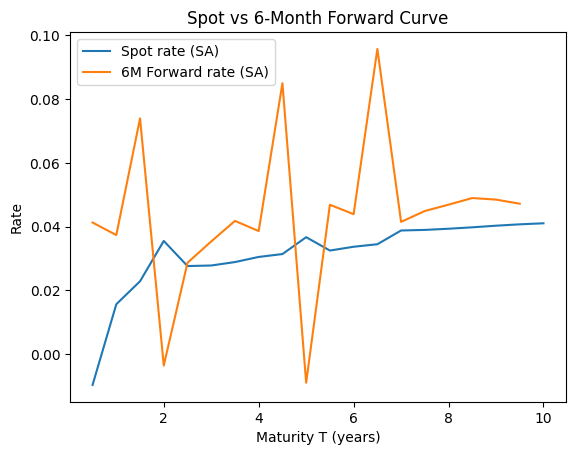

In [19]:
import matplotlib.pyplot as plt

# ---- Spot rates from zdf ----
spot = (
    zdf
    .with_columns([
        (2.0 * (pl.col("Z") ** (-1.0 / (2.0 * pl.col("T"))) - 1.0)).alias("spot rate (semi-annual)")
    ])
    .select(["T", "spot rate (semi-annual)"])
    .sort("T")
)

# ---- Forward rates from fwd ----
fwds = (
    fwd
    .select(["T", "forward rate (semi-annual)"])
    .sort("T")
)

# Convert to pandas/numpy for matplotlib (polars -> python lists is fine too)
T_spot = spot["T"].to_list()
r_spot = spot["spot rate (semi-annual)"].to_list()

T_fwd = fwds["T"].to_list()
r_fwd = fwds["forward rate (semi-annual)"].to_list()

plt.figure()
plt.plot(T_spot, r_spot, label="Spot rate (SA)")
plt.plot(T_fwd, r_fwd, label="6M Forward rate (SA)")
plt.xlabel("Maturity T (years)")
plt.ylabel("Rate")
plt.title("Spot vs 6-Month Forward Curve")
plt.legend()
plt.show()

In [20]:
max_row = (
    fwd
    .with_columns([
        (pl.col("T") + 0.5).alias("T2"),
    ])
    .select(["T", "T2", "forward rate (semi-annual)", "forward rate (continuous)", "forward discount"])
    .sort("forward rate (semi-annual)", descending=True)
    .head(1)
)

mr = max_row.row(0)
T1, T2, f_sa, f_cc, Fdisc = mr
print(f"Highest 6M forward is on ({T1:.2f}, {T2:.2f})")
print(f"forward (SA) = {f_sa:.4f}, forward (CC) = {f_cc:.4f}, forward DF = {Fdisc:.6f}")

Highest 6M forward is on (6.50, 7.00)
forward (SA) = 0.0958, forward (CC) = 0.0935, forward DF = 0.954308


- Forwards reflect the market’s implied “future short rates”. If the 6M forward rate starting at T is above the spot rate for maturity T, it generally indicates that rates are expected to be higher over the next interval than the average rate up to T.

***